# Mask out non-cluster members

In [ ]:
from astropy.cosmology import FlatLambdaCDM
from astropy.io import ascii
from astropy.stats import sigma_clipped_stats
import matplotlib.pyplot as plt
import numpy as np
import h5py

cutouts = h5py.File('../cutouts_550.hdf')
zs = ascii.read('../../data/processed/camira_final.tbl')['z_cl']
cosmo = FlatLambdaCDM(H0=68.4, Om0=0.301)

In [ ]:
# Convenience function for plotting the images
stddev = 0.017359
def stretch(img):
    return np.arcsinh(np.clip(img, a_min=0.0, a_max=10.0) / stddev)

In [ ]:
from photutils.background import Background2D
from scipy.interpolate import CloughTocher2DInterpolator

def background_estimate(cutout, mask=None):
    """
    Returns an estimate of the 2D background of `cutout`. The background is 
    measured in boxes of size 50px around the edges of the image, and the
    background is interpolated over the entire image. 
    """
    # Run photutil's Background2D for the low resolution grid
    bkg_initial = Background2D(cutout, box_size=50, mask=mask)
    mesh = bkg_initial.background_mesh
    
    # Extract just the edges of the mesh
    size_x = mesh.shape[0]
    size_y = mesh.shape[1]
    xvals = np.arange(0, size_x)
    yvals = np.arange(0, size_y)

    box_size = 50
    box_cen = (box_size - 1) / 2.0

    top = np.column_stack((xvals, (size_y - 1) * np.ones(size_x, dtype=int)))
    bottom = np.column_stack((xvals, np.zeros(size_x, dtype=int)))
    left = np.column_stack((np.zeros(size_y, dtype=int), yvals))
    right = np.column_stack(((size_x - 1) * np.ones(size_y, dtype=int), yvals))

    # Indices of edges
    square = np.unique(np.concatenate((top, bottom, left, right), axis=0), axis=0)
    # Pixel locations of centres of edge boxes
    real_square = box_size * square + box_cen

    # Get the values from the mesh corresponding to the coordinates
    vals = np.array([mesh[tuple(c)] for c in square])

    # Interpolate between the edges of the square
    interp = CloughTocher2DInterpolator(real_square, vals)
    x = np.arange(np.min(real_square[:,0]), np.max(real_square[:,0]))
    y = np.arange(np.min(real_square[:,1]), np.max(real_square[:,1]))
    x, y = np.meshgrid(x, y) # 2D grid
    z = interp(x, y).T

    # Expand the image to the correct size
    edge_widths = (
        (int(np.abs(cutout.shape[0] - z.shape[0])/2), 
        int(np.ceil(np.abs(cutout.shape[0] - z.shape[0])/2))),
        (int(np.abs(cutout.shape[1] - z.shape[1])/2),
        int(np.ceil(np.abs(cutout.shape[1] - z.shape[1])/2)))
    )
    bkg = np.pad(z, pad_width=edge_widths, mode='reflect')

    # Return background estimation
    return bkg

def create_circular_mask(z, img, cosmo, radius_kpc=130):
    """
    Returns a circular mask of 130kpc radius for given `z` and given cosmology
    `cosmo` for image `img`.
    """
    # Calculate the radius in pixels
    arcsec_to_px = 1/0.168
    radius = (cosmo.arcsec_per_kpc_proper(z) * radius_kpc).value * arcsec_to_px
    
    # Generate the mask
    centre = (img.shape[1] // 2, img.shape[0] // 2)
    Y, X = np.ogrid[:img.shape[0], :img.shape[1]]
    dist_from_centre = np.sqrt((X-centre[0])**2 + (Y-centre[1])**2)

    mask = dist_from_centre <= radius

    return mask

def counts2sb(counts, z):
    return 2.5 * np.log10(63095734448.0194 / counts) + 5 * np.log10(0.168) - 10 * np.log10(1+z)

def sb2counts(sb): # without reaccounting for dimming
    return 10**(-0.4*(sb - 2.5*np.log10(63095734448.0194) - 5.*np.log10(0.168)))

## Try masking out sources that have surface brightness > than the BCG
Not sure whether this will actually be useful, but I think that a few of the lowest ICL fractions end up there because of foreground galaxies contributing when they should be excluded.

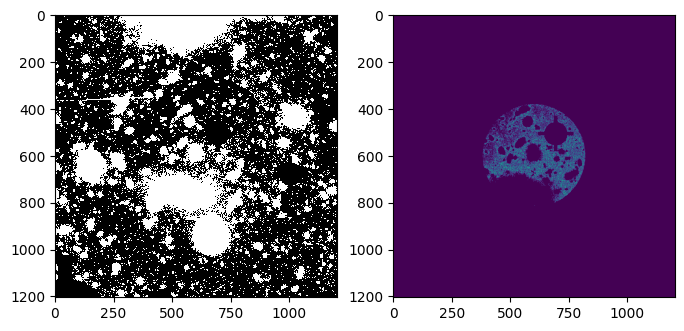

In [99]:
from skimage.segmentation import watershed

# Threshold the image with 25 (26?) mag threshold
cutout_idx = 33
cutout = np.array(cutouts[str(cutout_idx)]['HDU0']['DATA'])
bad_mask = (np.array(cutouts[str(cutout_idx)]['HDU1']['DATA']).astype(int) & (1 | 512)).astype(bool)

bkg = background_estimate(cutout, mask=bad_mask, z=zs[cutout_idx], cosmo=cosmo)
img = cutout - bkg

sb_img = counts2sb(img, 0)
threshold = 26 + 10 * np.log10(1 + zs[cutout_idx])
mask = sb_img > threshold

circ_mask = create_circular_mask(zs[cutout_idx], cutout, cosmo, radius_kpc=200)

obj_mask = ~(mask + bad_mask + np.isnan(sb_img))

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(obj_mask, cmap='gray', interpolation='none')
plt.subplot(122)
plt.imshow(stretch(img) * ~bad_mask * mask * circ_mask) 
plt.show()

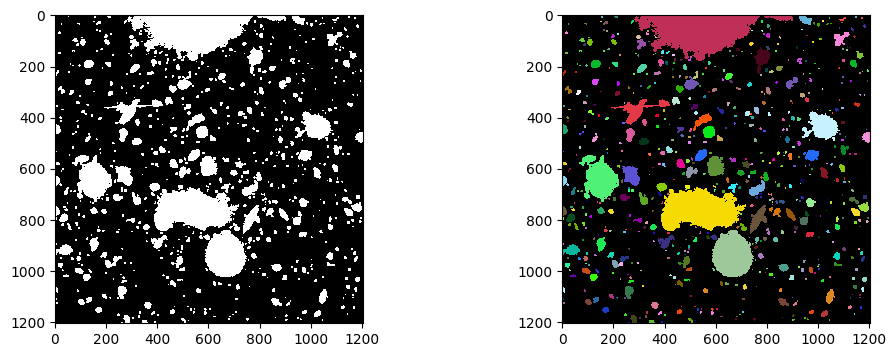

In [100]:
from skimage.morphology import binary_opening
from matplotlib.colors import ListedColormap
import cv2

# Erode and dilate the mask to get rid of the specks
obj_mask_open = binary_opening(obj_mask, np.ones((5,5)))
binary_img = np.array(obj_mask_open, dtype=np.uint8)

# Segment the image using connected components method
_, labels = cv2.connectedComponents(binary_img, connectivity=8)

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(obj_mask_open, cmap='gray', interpolation='none')
plt.subplot(122)
colours = np.random.rand(256, 3)
colours[0] = [0,0,0]
cmap = ListedColormap(colours)
plt.imshow(labels, cmap=cmap, interpolation='none')
plt.show()

# Oversegmenting the large galaxy but that might be okay

In [101]:
# Measure the surface brightness of areas corresponding to each label
mid = (cutout.shape[0] // 2, cutout.shape[1] // 2)
bcg_label = labels[mid]
bcg_mask = (labels == bcg_label)
bcg_sb = 2.5 * np.log10(63095734448.0194 * 0.168 ** 2 * np.sum(bcg_mask) / (np.sum(cutout * bcg_mask)))

num_labels = np.max(labels)
brighter_obj = []
for label in np.unique(labels):
    mask = (labels == label)
    sb = 2.5 * np.log10(63095734448.0194 * 0.168 ** 2 * np.sum(mask) / (np.sum(cutout * mask)))
    if sb < bcg_sb:
        print(sb)
        brighter_obj.append(label)

22.753621841232224
23.000350337780272
23.369978544039096


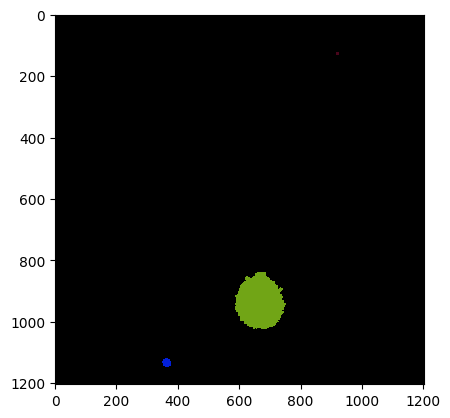

In [102]:
cmap = ListedColormap(colours)
plt.imshow(labels * np.isin(labels, brighter_obj), cmap=cmap, interpolation='none')
plt.show()

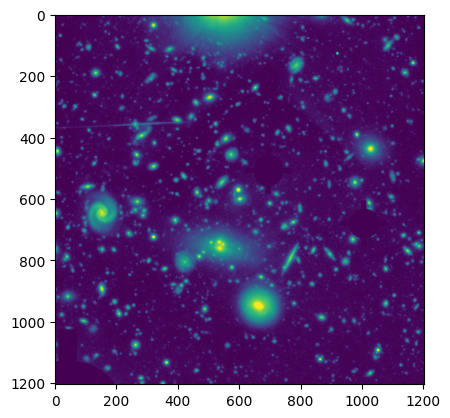

In [103]:
plt.imshow(stretch(img) * ~bad_mask)
plt.show()